In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d0f6e60819f9a5a.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccf708985967f09.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccbc2c5d1aaf078.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bdcc23296db1516.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9cb97f87870407f0.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bf9cca507923334.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c077ad23a231abb.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6a6499354e3197.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c3f1c10ba54ed56.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6acb154f9932c8.jpg
/kaggle/in

In [2]:
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,DenseNet169,VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

2025-08-28 08:52:32.866345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756371153.246200      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756371153.366525      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
img_size = (224,224)
batch_size = 128

In [4]:
train_ds = image_dataset_from_directory(
    "/kaggle/input/plant-disease-recognition-dataset/Train/Train",
    validation_split=0,
    seed = 42,
    image_size = img_size,
    batch_size=batch_size
)

Found 1322 files belonging to 3 classes.


I0000 00:00:1756371174.727766      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756371174.728454      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
test_ds = image_dataset_from_directory(
    "/kaggle/input/plant-disease-recognition-dataset/Test/Test",
    validation_split=0,
    seed = 42,
    image_size = img_size,
    batch_size=batch_size
)

Found 150 files belonging to 3 classes.


In [6]:
val_ds = image_dataset_from_directory(
    "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation",
    validation_split=0,
    seed = 42,
    image_size = img_size,
    batch_size=batch_size
)

Found 60 files belonging to 3 classes.


In [7]:
dt_aug = Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomTranslation(0.3,0.2),
    layers.RandomZoom(0.25),    
    layers.RandomTranslation(0.1, 0.1)
])

In [8]:
def preprocess(images,labels,augment=False):
  images = tf.cast(images,tf.float32)/255.0
  if augment:
    images = dt_aug(images)
  return images,labels

In [9]:
import tensorflow as tf
# Apply preprocessing
train_ds = train_ds.map(lambda x,y:preprocess(x,y,augment=True))
test_ds = test_ds.map(lambda x,y:preprocess(x,y))
val_ds = val_ds.map(lambda x,y:preprocess(x,y))

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(64, activation='relu'), 
    Dropout(0.6),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer=Adam(0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])

In [12]:
stop = EarlyStopping(patience=3, restore_best_weights=True)

In [13]:
history = model.fit(train_ds,epochs=10,verbose=1,validation_data=val_ds,callbacks=stop)

Epoch 1/10


I0000 00:00:1756371187.790531      66 service.cc:148] XLA service 0x7e0010006fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756371187.792292      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756371187.792328      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756371188.496102      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756371204.612283      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - acc: 0.3137 - loss: 3.7456 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.3106 - loss: 1.0993 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.3119 - loss: 1.0985 - val_acc: 0.3333 - val_loss: 1.0984
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.3187 - loss: 1.0970 - val_acc: 0.3333 - val_loss: 1.0903
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.3127 - loss: 1.1047 - val_acc: 0.5333 - val_loss: 1.0963
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.3625 - loss: 1.0893 - val_acc: 0.3667 - val_loss: 1.0744
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - acc: 0.4015 - loss: 1.0761 - val_acc: 0.3667 - val_loss: 1.0365
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.4266 - loss: 1.0566 - val_acc: 0.5500 - val_loss: 1.0268
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - acc: 0.4286 - loss: 1.0421 - va

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - acc: 0.4963 - loss: 0.9534


In [15]:
base_model_VGG16 = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in base_model_VGG16.layers:
  layer.trainable = False
model_VGG16 = Sequential([
    base_model_VGG16,
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
model_VGG16.compile(optimizer=Adam(0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_VGG16 = model_VGG16.fit(train_ds,epochs=10,validation_data=val_ds)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


2025-08-28 09:00:26.268214: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-28 09:00:26.428957: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.160848338s
Trying algorithm eng12{k11=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

11/11 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.3731 - loss: 3.0232 - val_accuracy: 0.6333 - val_loss: 0.8586
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5373 - loss: 1.0022 - val_accuracy: 0.8500 - val_loss: 0.6670
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6293 - loss: 0.8056 - val_accuracy: 0.8833 - val_loss: 0.5442
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6970 - loss: 0.7331 - val_accuracy: 0.9000 - val_loss: 0.4697
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7240 - loss: 0.6467 - val_accuracy: 0.9333 - val_loss: 0.4473
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7183 - loss: 0.6584 - val_accuracy: 0.8000 - val_loss: 0.4630
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7287 - loss: 0.6574 - val_accuracy: 0.9333 - val_loss: 0.3836
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7545 - loss: 0.5962 - val_accuracy: 0.9500 - val_loss: 0.3545
Ep

In [16]:
test_loss_vgg, test_accuracy_vgg = model_VGG16.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 12s/step - accuracy: 0.8969 - loss: 0.4442


In [17]:
base_model_ResNet = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in base_model_ResNet.layers:
    layer.trainable = False
model_ResNet = Sequential([
    base_model_ResNet,
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
model_ResNet.compile(optimizer=Adam(0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])
history_ResNet = model_ResNet.fit(train_ds,epochs=10,validation_data=val_ds)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - acc: 0.3336 - loss: 6.1911 - val_acc: 0.3333 - val_loss: 1.1843
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.3362 - loss: 1.1789 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.3249 - loss: 1.0986 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.3343 - loss: 1.1112 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.3130 - loss: 1.0986 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - acc: 0.3685 - loss: 1.0985 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - acc: 0.3481 - loss: 1.0985 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - acc: 0.3574 - loss: 1.0985 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 9/10
11/11 ━━━━

In [18]:
test_loss_res, test_accuracy_res = model_ResNet.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - acc: 0.3316 - loss: 1.0986


In [19]:
def evaluate_model(model, test_dts=test_ds, class_names=None):
    y_true=[]
    y_preds=[]
    for image,labels in test_dts:
        pred = model.predict(test_dts)
        y_preds.extend(pred)
        y_true.extend(labels.numpy() if hasattr(labels, 'numpy') else labels)
    y_true = np.array(y_true)
    y_preds = np.array(y_preds)
    min_length = min(len(y_true), len(y_preds))
    y_true = y_true[:min_length]
    y_preds = y_preds[:min_length]
    y_pred = np.argmax(y_preds,axis=1)
    
    report = classification_report(y_true, y_pred, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred)
    
    print('Classification Report')
    print(report)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step
Classification Report
              precision    recall  f1-score   support

     Healthy       0.40      0.04      0.07        50
     Powdery       0.27      0.44      0.33        50
        Rust       0.29      0.36      0.32        50

    accuracy                           0.28       150
   macro avg       0.32      0.28      0.24       150
weighted avg       0.32      0.28      0.24       150



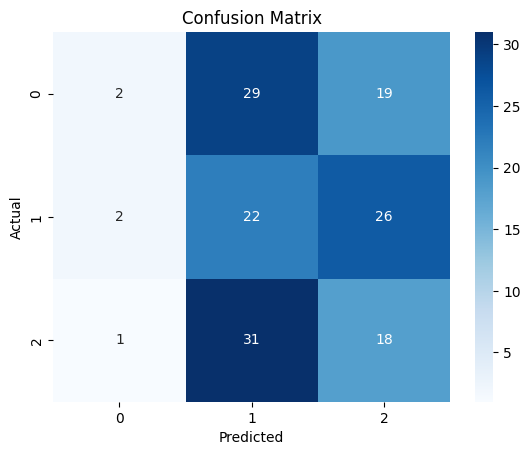

In [20]:
import matplotlib.pyplot as plt
evaluate_model(model,class_names=['Healthy','Powdery','Rust'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step
Classification Report
              precision    recall  f1-score   support

     Healthy       0.37      0.36      0.36        50
     Powdery       0.26      0.24      0.25        50
        Rust       0.28      0.30      0.29        50

    accuracy                           0.30       150
   macro avg       0.30      0.30      0.30       150
weighted avg       0.30      0.30      0.30       150



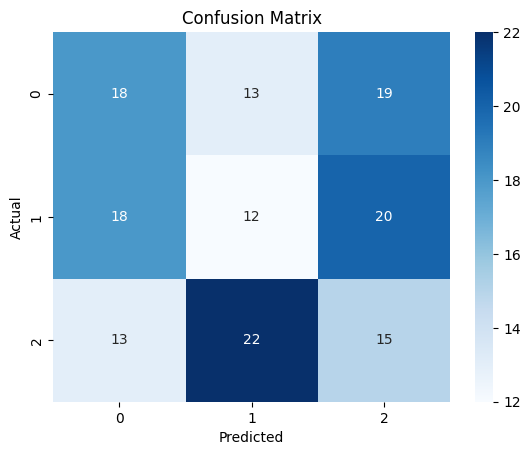

In [21]:
evaluate_model(model_VGG16,class_names=['Healthy','Powdery','Rust'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Classification Report
              precision    recall  f1-score   support

     Healthy       0.33      1.00      0.50        50
     Powdery       0.00      0.00      0.00        50
        Rust       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.11      0.33      0.17       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


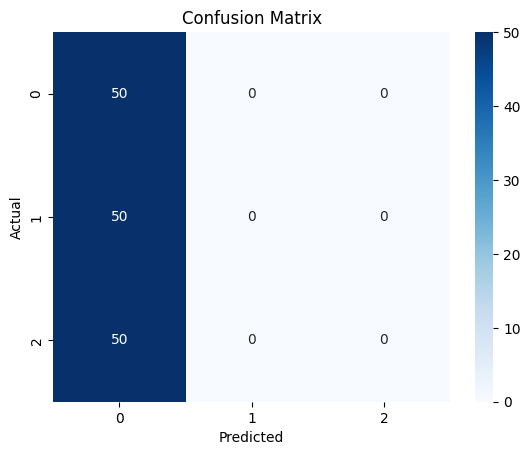

In [22]:
evaluate_model(model_ResNet,class_names=['Healthy','Powdery','Rust'])

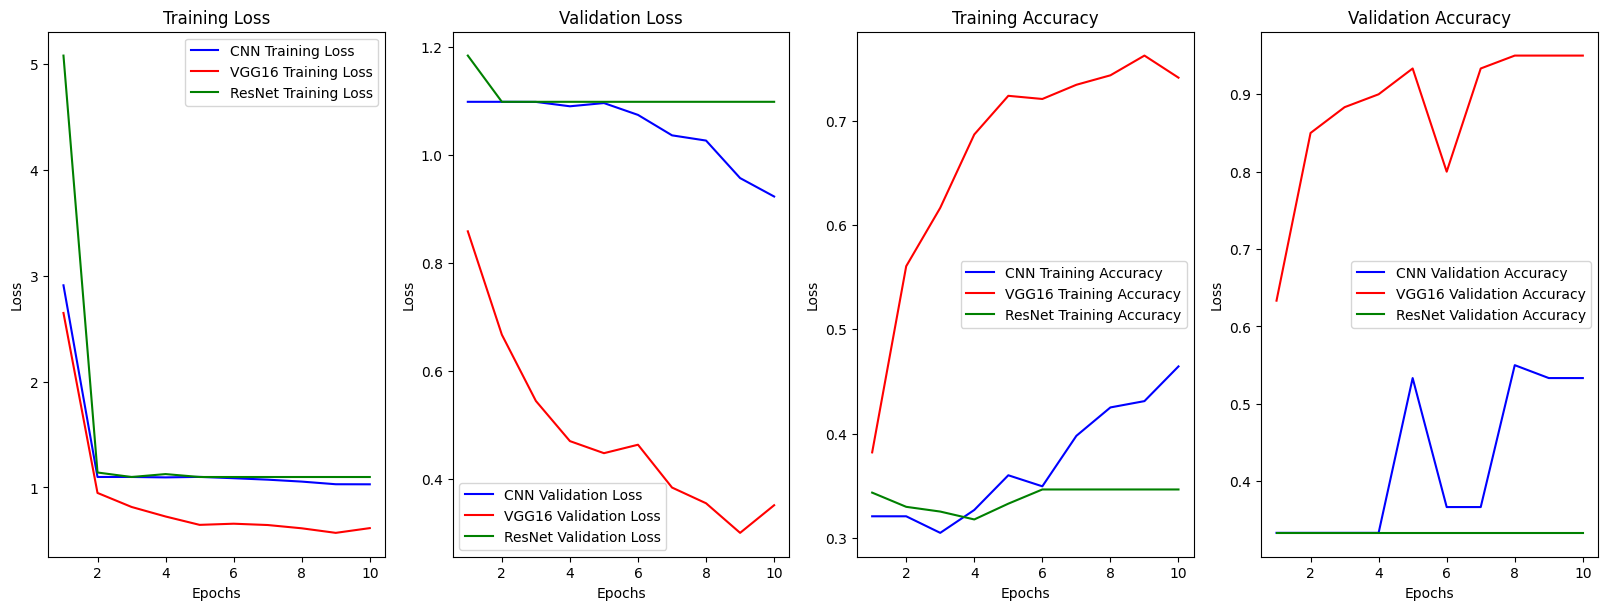

In [23]:
loss_cnn = history.history['loss']
loss_vgg = history_VGG16.history['loss']
loss_res = history_ResNet.history['loss']
####
val_loss_cnn = history.history['val_loss']
val_loss_vgg = history_VGG16.history['val_loss']
val_loss_res = history_ResNet.history['val_loss']
####
acc_cnn = history.history['acc']
acc_vgg = history_VGG16.history['accuracy']
acc_res = history_ResNet.history['acc']
####
val_acc_cnn = history.history['val_acc']
val_acc_vgg = history_VGG16.history['val_accuracy']
val_acc_res = history_ResNet.history['val_acc']
####
epochs = range(1, len(loss_cnn) + 1)

# Plot training and validation loss
plt.figure(figsize=(20, 15))
plt.subplot(2, 4, 1)
plt.plot(epochs, loss_cnn, 'b', label='CNN Training Loss')
plt.plot(epochs, loss_vgg, 'r', label='VGG16 Training Loss')
plt.plot(epochs, loss_res, 'g', label='ResNet Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 4, 2)
plt.plot(epochs, val_loss_cnn, 'b', label='CNN Validation Loss')
plt.plot(epochs, val_loss_vgg, 'r', label='VGG16 Validation Loss')
plt.plot(epochs, val_loss_res, 'g', label='ResNet Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 4, 3)
plt.plot(epochs, acc_cnn, 'b', label='CNN Training Accuracy')
plt.plot(epochs, acc_vgg, 'r', label='VGG16 Training Accuracy')
plt.plot(epochs, acc_res, 'g', label='ResNet Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 4, 4)
plt.plot(epochs, val_acc_cnn, 'b', label='CNN Validation Accuracy')
plt.plot(epochs, val_acc_vgg, 'r', label='VGG16 Validation Accuracy')
plt.plot(epochs, val_acc_res, 'g', label='ResNet Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()